In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import ssl
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import learning_curve
import seaborn as sns

ssl._create_default_https_context = ssl._create_unverified_context

## **Building and Training Model**

In [ ]:
# https://docs.google.com/spreadsheets/d/1s1vPP5aO9YaYgqGlRRV6G8Za36jCBPsggyLVQZGSn5c/edit?gid=0#gid=0
fl_districts_df = '__Final Training Set.xlsx'

fl_districts_df = pd.read_excel(fl_districts_df)
fl_districts_df = pd.get_dummies(fl_districts_df)
fl_districts_df['University R&D Spending'] = np.log1p(fl_districts_df['University R&D Spending'])

# drop per capita revenue + total revenue because it had the least feature importance -> reduces noise
fl_districts_df.drop(columns=['Year','# of Patent Applications in Florida','Population','Per Capita Revenue', 'Total Revenue - All Funds'], inplace=True)

# drops irrelevant counties where the patent application is 0
fl_districts_df = fl_districts_df[fl_districts_df['Patent Applications Per Capita'] != 0]

print(fl_districts_df.columns)

Index(['County Code', 'Business Applications', 'University R&D Spending',
       'Median Household Income',
       'State, Local and Federal Funds for Pupils by School County',
       'Governmental Funds - General', 'Governmental Funds - Special Revenue',
       'Governmental Funds - Debt Service',
       'Governmental Funds - Capital Projects',
       'Proprietary Funds - Enterprise',
       'Proprietary Funds - Internal Service',
       'Patent Applications Per Capita'],
      dtype='object')


<ipython-input-189-68f3a0ed70cf>:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  log_transformed_df = fl_districts_df[columns_to_transform].applymap(lambda x: np.log(x) if x > 0 else np.nan)
<ipython-input-189-68f3a0ed70cf>:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  sqrt_transformed_df = fl_districts_df[columns_to_transform].applymap(lambda x: np.sqrt(x) if x >= 0 else np.nan)


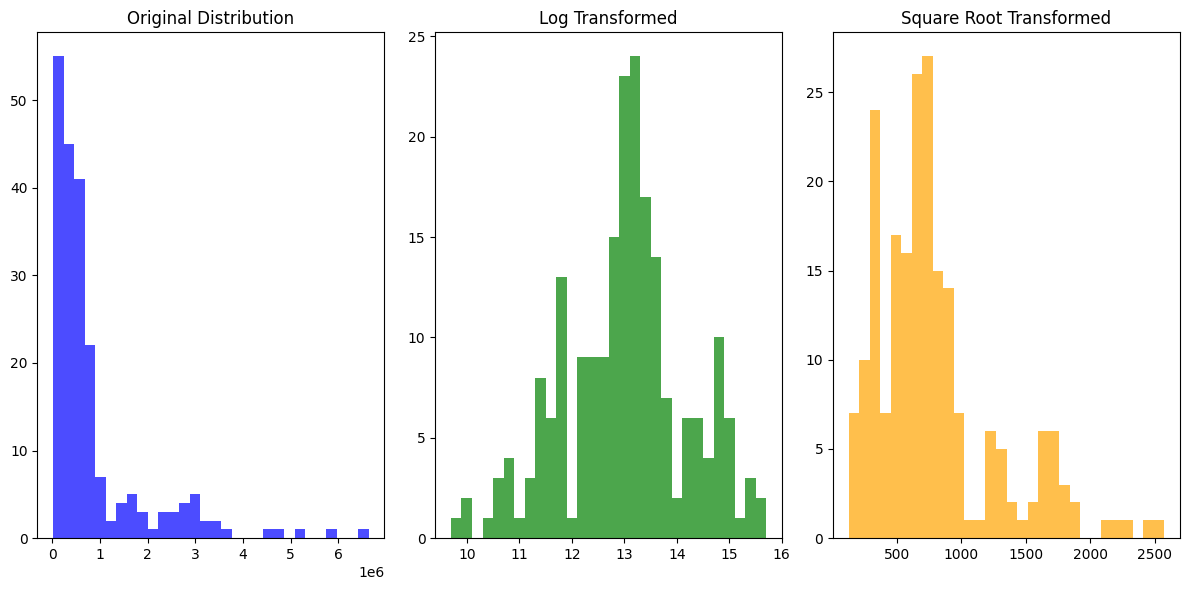

In [ ]:
# Apply transformations to normalize financial values
columns_to_transform = [
    'Median Household Income',
    'State, Local and Federal Funds for Pupils by School County',
    'Governmental Funds - General',
    'Governmental Funds - Special Revenue',
    'Governmental Funds - Debt Service',
    'Governmental Funds - Capital Projects',
    'Proprietary Funds - Enterprise',
    'Proprietary Funds - Internal Service'
    #'Total Revenue - All Funds'
    #'Per Capita Revenue'
]

# Apply Log Transformation (only for positive values)
log_transformed_df = fl_districts_df[columns_to_transform].applymap(lambda x: np.log(x) if x > 0 else np.nan)

# Apply Square Root Transformation (only for non-negative values)
sqrt_transformed_df = fl_districts_df[columns_to_transform].applymap(lambda x: np.sqrt(x) if x >= 0 else np.nan)

# Apply Box-Cox Transformation (only for positive values)
boxcox_transformed_df = pd.DataFrame()
for col in columns_to_transform:
    # Box-Cox can only be applied to positive data
    positive_data = fl_districts_df[col] > 0
    transformed, fitted_lambda = stats.boxcox(fl_districts_df.loc[positive_data, col])
    boxcox_transformed_df[col] = np.nan
    try:
      boxcox_transformed_df.loc[positive_data, col] = transformed
    except Exception as e:
      pass

# Visualize the distributions before and after transformation (example for 'Median Household Income')
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.hist(fl_districts_df['State, Local and Federal Funds for Pupils by School County'].dropna(), bins=30, color='blue', alpha=0.7)
plt.title('Original Distribution')

plt.subplot(1, 3, 2)
plt.hist(log_transformed_df['State, Local and Federal Funds for Pupils by School County'].dropna(), bins=30, color='green', alpha=0.7)
plt.title('Log Transformed')

plt.subplot(1, 3, 3)
plt.hist(sqrt_transformed_df['State, Local and Federal Funds for Pupils by School County'].dropna(), bins=30, color='orange', alpha=0.7)
plt.title('Square Root Transformed')

plt.tight_layout()
plt.show()

# The best distribution was achieved through log transform
for col in columns_to_transform:
    fl_districts_df[col] = log_transformed_df[col]

fl_districts_df.fillna(0, inplace=True)

In [ ]:
# Drop target variable from feature set
X = fl_districts_df.drop('Patent Applications Per Capita', axis=1)

# Target is only the inventors column
y = fl_districts_df['Patent Applications Per Capita']

#### **Creating random forest regressor**

In [ ]:
# Test diff params
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=19)

In [ ]:
rfr = RandomForestRegressor(random_state=13)
rfr.fit(X_train, y_train)

RandomForestRegressor(random_state=13)

In [ ]:
y_pred = rfr.predict(X_test)

#### **Initial model evalutation**

In [ ]:
mean_absolute_error(y_pred, y_test)

4.982468589548287e-05

In [ ]:
mean_squared_error(y_pred, y_test)

4.298081191317142e-09

In [ ]:
r2_score(y_pred, y_test)

0.717752731381628

#### **Feature Importance Analysis**

Feature Importances:
                                               Feature  Importance
2                             University R&D Spending    0.387057
0                                         County Code    0.170936
6                Governmental Funds - Special Revenue    0.076271
5                        Governmental Funds - General    0.072399
10               Proprietary Funds - Internal Service    0.061203
9                      Proprietary Funds - Enterprise    0.048849
1                               Business Applications    0.040460
8               Governmental Funds - Capital Projects    0.028668
4   State, Local and Federal Funds for Pupils by S...    0.027141
3                             Median Household Income    0.026610
7                   Governmental Funds - Debt Service    0.024967
11                          Total Revenue - All Funds    0.020265
12                                 Per Capita Revenue    0.015172


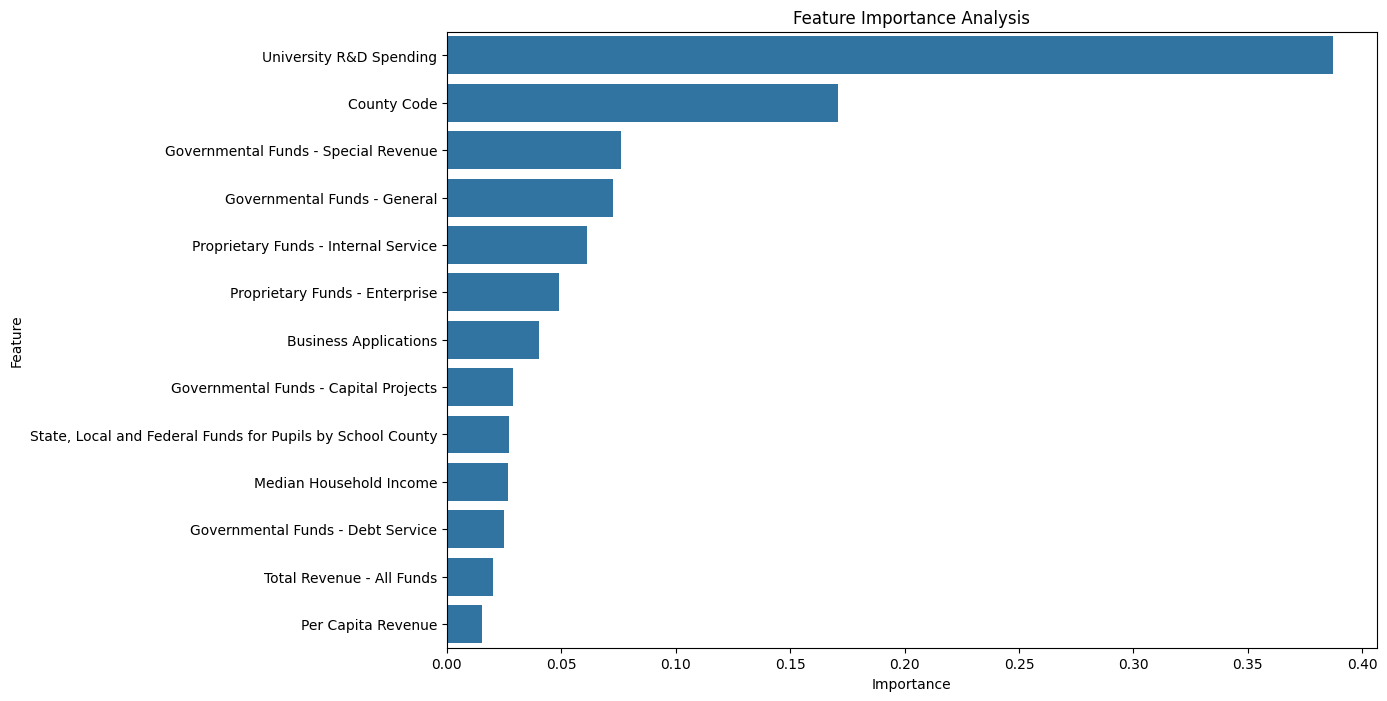

In [ ]:
# Extract feature importances
feature_importances = rfr.feature_importances_

# Create a DataFrame to hold feature names and their importance
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance (descending order)
importance_df = importance_df.sort_values(by='Importance', ascending=False)
#importance_df = importance_df[importance_df['Feature'] != 'County Code']
# Display the feature importances
print("Feature Importances:\n", importance_df)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance Analysis')
plt.show()

                                              Feature  Median Importance
2                             University R&D Spending           0.302189
10               Proprietary Funds - Internal Service           0.194097
5                        Governmental Funds - General           0.165165
0                                         County Code           0.130920
9                      Proprietary Funds - Enterprise           0.062788
8               Governmental Funds - Capital Projects           0.052014
1                               Business Applications           0.046650
4   State, Local and Federal Funds for Pupils by S...           0.043502
6                Governmental Funds - Special Revenue           0.042304
7                   Governmental Funds - Debt Service           0.031542
3                             Median Household Income           0.030409


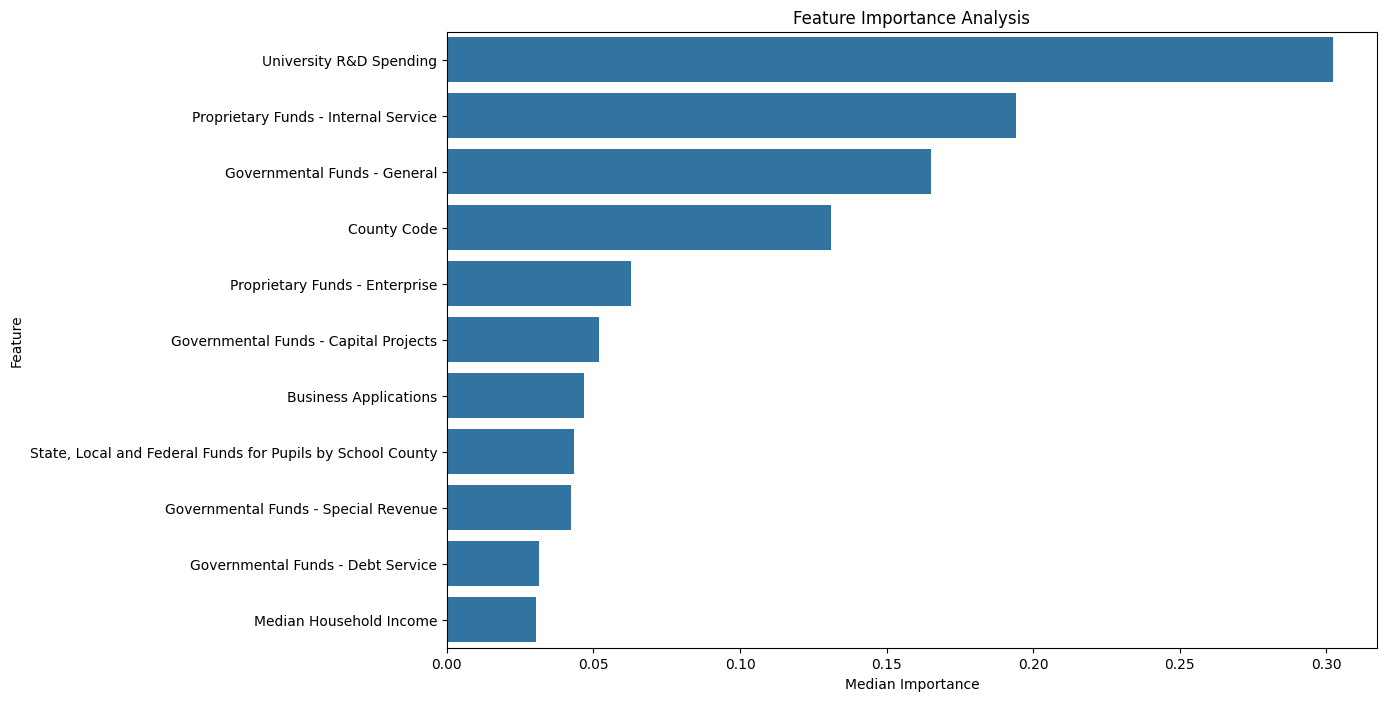

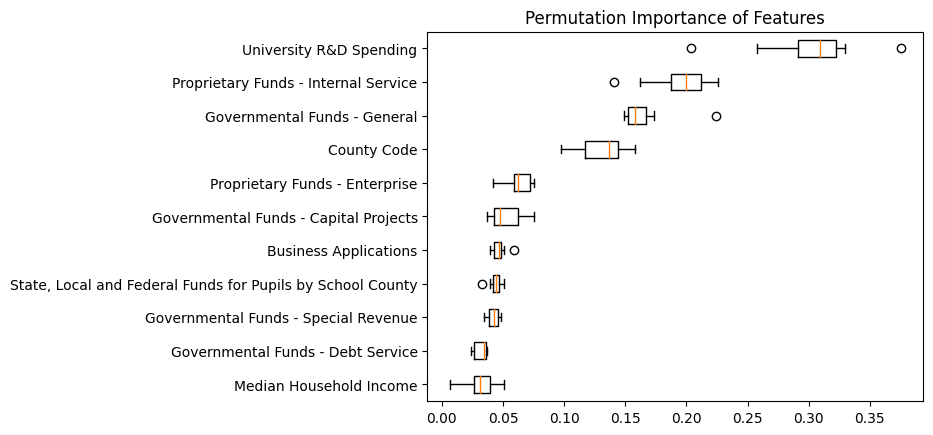

Horizontal Axis (Importance): This axis shows the importance values. The further right a box is, the more important the feature is for the model.

Box Plots: Each feature's importance is represented by a box plot. The box plot shows the distribution of importance scores for the feature based on multiple shuffles.

Box Width: Indicates the spread or variability in the importance score across different shuffles. A wide box means the feature's importance varies more depending on how it’s perturbed.
Median Line (Orange Line): Represents the median importance score for that feature.
Whiskers and Outliers: The whiskers extend to show the range of values that are not considered outliers, and any points outside the whiskers are outliers.


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

# Explore interactions between the most important features identified in model
# Diff features work together to influence target variable
result = permutation_importance(rfr, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = result.importances_mean.argsort()

# Create a DataFrame to hold feature names and their median importance
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Median Importance': result.importances_mean
})

# Sort by the median importance and print it
importance_df = importance_df.sort_values(by='Median Importance', ascending=False)
print(importance_df)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Median Importance', y='Feature', data=importance_df)
plt.title('Feature Importance Analysis')
plt.show()

plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=X_test.columns[sorted_idx])
plt.title("Permutation Importance of Features")
plt.show()
print("""Horizontal Axis (Importance): This axis shows the importance values. The further right a box is, the more important the feature is for the model.

Box Plots: Each feature's importance is represented by a box plot. The box plot shows the distribution of importance scores for the feature based on multiple shuffles.

Box Width: Indicates the spread or variability in the importance score across different shuffles. A wide box means the feature's importance varies more depending on how it’s perturbed.
Median Line (Orange Line): Represents the median importance score for that feature.
Whiskers and Outliers: The whiskers extend to show the range of values that are not considered outliers, and any points outside the whiskers are outliers.""")

In [ ]:
!pip install shap

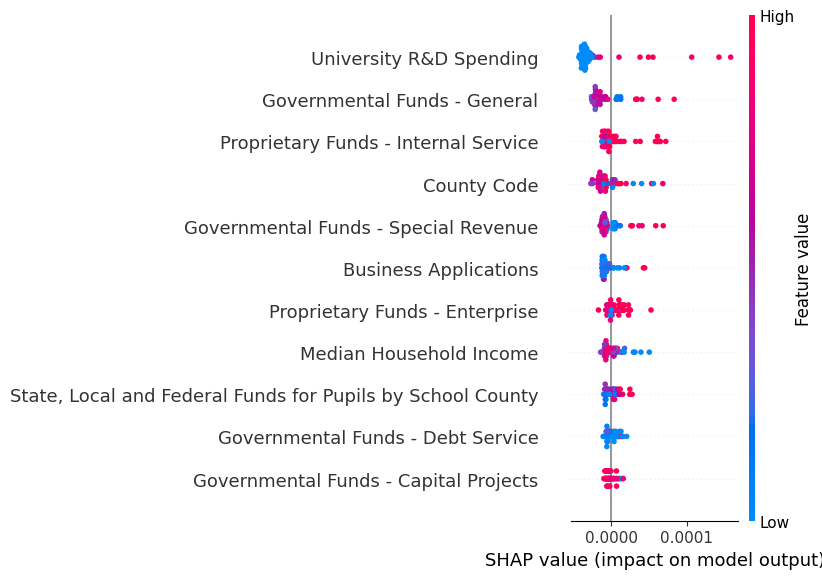

In [ ]:
import shap

# SHAP values provide a detailed breakdown of the contribution of each feature to a single prediction, offering insights into model predictions at an individual level.
explainer = shap.TreeExplainer(rfr)
shap_values = explainer.shap_values(X_test)

# Plot a summary of SHAP values
shap.summary_plot(shap_values, X_test)

In [ ]:
from sklearn.utils import resample

n_iterations = 100
predictions = np.zeros((n_iterations, len(y_test)))

for i in range(n_iterations):
    X_resampled, y_resampled = resample(X_train, y_train)
    model = RandomForestRegressor(random_state=42)
    model.fit(X_resampled, y_resampled)
    predictions[i, :] = model.predict(X_test)

prediction_uncertainty = np.std(predictions, axis=0)
plt.figure(figsize=(10, 6))
plt.hist(prediction_uncertainty, bins=50, color='purple')
plt.title("Prediction Uncertainty")
plt.xlabel("Standard Deviation of Predictions")
plt.ylabel("Frequency")
plt.show()

KeyboardInterrupt: 

In [ ]:
# After training your model and making predictions
train_pred = rfr.predict(X_train)
test_pred = rfr.predict(X_test)

# Training performance
print("Training Set Performance:")
print("MAE:", mean_absolute_error(y_train, train_pred))
print("MSE:", mean_squared_error(y_train, train_pred))
print("R2 Score:", r2_score(y_train, train_pred))

# Testing performance
print("\nTest Set Performance:")
print("MAE:", mean_absolute_error(y_test, test_pred))
print("MSE:", mean_squared_error(y_test, test_pred))
print("R2 Score:", r2_score(y_test, test_pred))

Training Set Performance:
MAE: 2.2849835469922673e-05
MSE: 1.2097232023050093e-09
R2 Score: 0.9722619420547626

Test Set Performance:
MAE: 4.9752976857644776e-05
MSE: 4.307804421356169e-09
R2 Score: 0.8280717020119326


In [ ]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation
cv_scores = cross_val_score(rfr, X, y, cv=5, scoring='neg_mean_squared_error')

# Print cross-validation results
print("Cross-validation scores (MSE):", -cv_scores)
print("Average CV score (MSE):", -cv_scores.mean())

Cross-validation scores (MSE): [6.07405336e-09 5.25564282e-09 3.55865174e-09 3.64513047e-09
 7.33847845e-09]
Average CV score (MSE): 5.174391368037812e-09


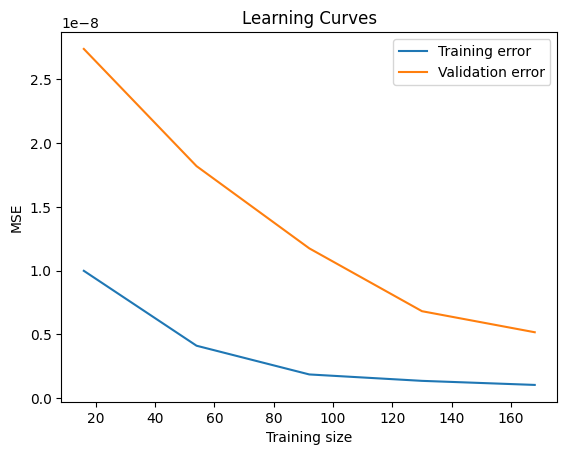

In [ ]:
# Generate learning curves
train_sizes, train_scores, test_scores = learning_curve(rfr, X, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5))

# Compute the mean and std deviation of training and test scores
train_scores_mean = -train_scores.mean(axis=1)
test_scores_mean = -test_scores.mean(axis=1)

# Plot learning curves
plt.figure()
plt.plot(train_sizes, train_scores_mean, label="Training error")
plt.plot(train_sizes, test_scores_mean, label="Validation error")
plt.ylabel("MSE")
plt.xlabel("Training size")
plt.title("Learning Curves")
plt.legend()
plt.show()

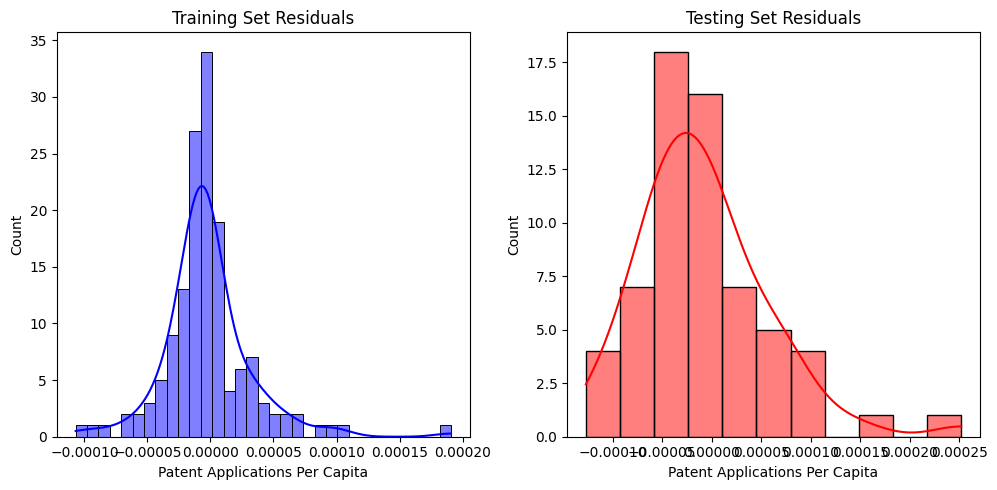

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate residuals for training and testing sets
train_residuals = y_train - train_pred
test_residuals = y_test - test_pred

# Plot residuals
plt.figure(figsize=(10, 5))

# Training residuals
plt.subplot(1, 2, 1)
sns.histplot(train_residuals, kde=True, color="blue")
plt.title("Training Set Residuals")

# Testing residuals
plt.subplot(1, 2, 2)
sns.histplot(test_residuals, kde=True, color="red")
plt.title("Testing Set Residuals")

plt.tight_layout()
plt.show()


#### **Hyperparameter tuning** (makes performance worse for some reason)

In [ ]:
param_grid = {
    # num of decision trees
    'n_estimators':[10, 100, 200],
    # depth of each tree
    'max_depth':[2,5,10],
    # num of samples required to split an internal node
    'min_samples_split':[2,5,10],
    # num of samples required to split a leaf node
    'min_samples_leaf':[1,2,4]
}
rfr_cv = GridSearchCV(estimator=rfr, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

In [ ]:
# Refit the model
rfr_cv.fit(X_train, y_train)

# New predictions
y_pred = rfr_cv.predict(X_test)

#### **Tuned model evaluation**

In [ ]:
mean_absolute_error(y_pred, y_test)

5.4239292978785316e-05

In [ ]:
mean_squared_error(y_pred, y_test)

5.447561554466795e-09

In [ ]:
r2_score(y_pred, y_test)

0.6176406685055558

#### **Feature Importance Tuned Model**

In [ ]:
# Extract and display feature importances for the tuned model
feature_importances_tuned = rfr_cv.best_estimator_.feature_importances_

importance_df_tuned = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances_tuned
})

importance_df_tuned = importance_df_tuned.sort_values(by='Importance', ascending=False)
print(importance_df_tuned)


                                              Feature  Importance
2                             University R&D Spending    0.448773
0                                         County Code    0.120507
9                      Proprietary Funds - Enterprise    0.084835
10               Proprietary Funds - Internal Service    0.081597
6                Governmental Funds - Special Revenue    0.068312
4   State, Local and Federal Funds for Pupils by S...    0.059922
8               Governmental Funds - Capital Projects    0.042384
3                             Median Household Income    0.035410
5                        Governmental Funds - General    0.028778
7                   Governmental Funds - Debt Service    0.015393
1                               Business Applications    0.014089


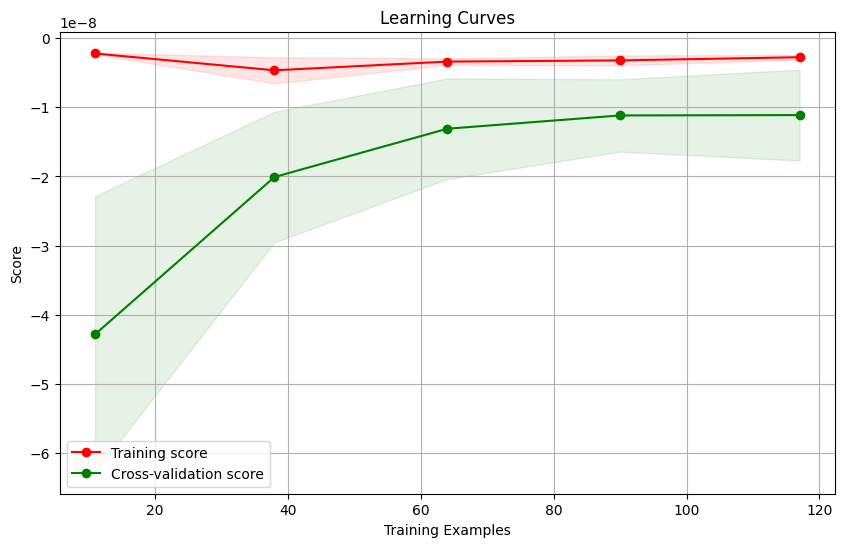

In [ ]:
def plot_learning_curve(estimator, X, y, cv=None, scoring='neg_mean_squared_error', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)):
    plt.figure(figsize=(10, 6))

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.title('Learning Curves')
    plt.xlabel('Training Examples')
    plt.ylabel('Score')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

# Generate learning curves for the tuned model
plot_learning_curve(rfr_cv.best_estimator_, X_train, y_train, cv=5)

## **Preparing Training Dataset**
#### **R&D by college**

In [ ]:

!pip install FuzzyWuzzy
import pandas as pd
import requests
from io import BytesIO
from fuzzywuzzy import fuzz, process

# List of Florida universities
florida_universities = [
    "U. of Florida",
    "Florida State U.",
    "U. of Miami",
    "U. of Central Florida",
    "U. of South Florida",
    "Florida International U.",
    "Florida Atlantic U.",
    "Florida A&M U.",
    "U. of North Florida",
    "Florida Gulf Coast U.",
    "New College of Florida",
    "Stetson U.",
    "Eckerd C.",
    "Barry U.",
    "Embry-Riddle Aeronautical U.",
    "Florida Institute of Technology",
    "Rollins C.",
    "U. of Tampa",
    "Jacksonville U.",
    "Bethune-Cookman U."
]

# URL to download the data
url = "https://ncsesdata.nsf.gov/profiles/site?method=downloadRankings&src=HERD&s=&o="

# Scrape the dataset and load into a BytesIO object
response = requests.get(url)
file_content = BytesIO(response.content)

# Load the dataset into a pandas DataFrame directly from the BytesIO object
df = pd.read_excel(file_content, skiprows=2, header=[0,1])

# Drop the first level of the header (the one with the years)
df.columns = df.columns.droplevel(0)
df.drop(columns=['R&D expenditures.1'], inplace=True)

# Generate new column names by concatenating with the appropriate year
new_columns = ['Institution']
years = list(range(2022, 2012, -1))  # From 2022 to 2013

for year in years:
    new_columns.extend([f'Rank {year}', f'Percentile {year}', f'R&D Expenditures {year}'])

df.columns = new_columns

# Use FuzzyWuzzy to find the best matches for each Florida university
matches = []
for university in florida_universities:
    best_match = process.extractOne(university, df['Institution'], scorer=fuzz.token_sort_ratio)
    if best_match and best_match[1] > 80:  # Only consider matches with a score above 80
        matches.append(best_match[0])

# Filter the DataFrame for the matched universities
filtered_df = df[df['Institution'].isin(matches)]
filtered_df.reset_index(drop=True, inplace=True)

# Display the filtered DataFrame
print(filtered_df)


/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


                        Institution  Rank 2022  Percentile 2022  \
0                        U. Florida       25.0            97.33   
1                          U. Miami       69.0            92.43   
2                  U. South Florida       75.0            91.76   
3                  Florida State U.       82.0            90.98   
4          Florida International U.      101.0            88.86   
5                U. Central Florida      122.0            86.53   
6               Florida Atlantic U.      197.0            78.17   
7                    Florida A&M U.      212.0            76.50   
8      Embry-Riddle Aeronautical U.      255.0            71.71   
9                  U. North Florida      297.0            67.04   
10  Florida Institute of Technology      304.0            66.26   
11            Florida Gulf Coast U.      352.0            60.91   
12               Bethune-Cookman U.      711.0            20.93   
13                        Eckerd C.      746.0            17.0

#### **R&D by county**

In [ ]:
!pip install fuzzywuzzy
import pandas as pd
import requests
from io import BytesIO
from fuzzywuzzy import fuzz, process

university_to_county = {
    "U. Florida": "Alachua",
    "U. Miami": "Miami-Dade",
    "U. South Florida": "Hillsborough",
    "Florida State U.": "Leon",
    "Florida International U.": "Miami-Dade",
    "U. Central Florida": "Orange",
    "Florida Atlantic U.": "Palm Beach",
    "Florida A&M U.": "Leon",
    "Embry-Riddle Aeronautical U.": "Volusia",
    "U. North Florida": "Duval",
    "Florida Institute of Technology": "Brevard",
    "Florida Gulf Coast U.": "Lee",
    "Bethune-Cookman U.": "Volusia",
    "Eckerd C.": "Pinellas",
    "Stetson U.": "Volusia",
    "Rollins C.": "Orange",
    "Barry U.": "Miami-Dade",
    "Jacksonville U.": "Duval",
    "New College of Florida": "Sarasota",
    "U. Tampa": "Hillsborough"
}

# URL to download the data
url = "https://ncsesdata.nsf.gov/profiles/site?method=downloadRankings&src=HERD&s=&o="

# Scrape the dataset and load into a BytesIO object
response = requests.get(url)
file_content = BytesIO(response.content)

# Load the dataset into a pandas DataFrame directly from the BytesIO object
df = pd.read_excel(file_content, skiprows=2, header=[0,1])

# Drop the first level of the header (the one with the years)
df.columns = df.columns.droplevel(0)
df.drop(columns=['R&D expenditures.1'], inplace=True)

# Generate new column names by concatenating with the appropriate year
new_columns = ['Institution']
years = list(range(2022, 2012, -1))  # From 2022 to 2013

for year in years:
    new_columns.extend([f'Rank {year}', f'Percentile {year}', f'R&D Expenditures {year}'])

df.columns = new_columns

# Use FuzzyWuzzy to find the best matches for each Florida university
matches = []
for university in university_to_county.keys():
    best_match = process.extractOne(university, df['Institution'], scorer=fuzz.token_sort_ratio)
    if best_match and best_match[1] > 80:  # Only consider matches with a score above 80
        matches.append((best_match[0], university_to_county[university]))

# Create a DataFrame with the matched universities and their corresponding counties
filtered_df = df[df['Institution'].isin([match[0] for match in matches])].copy()
filtered_df['County'] = filtered_df['Institution'].map(dict(matches))

# Aggregate R&D Expenditures by County and Year
county_rnd_df = filtered_df.groupby('County').agg({f'R&D Expenditures {year}': 'sum' for year in years}).reset_index()

# Display the new DataFrame
print(county_rnd_df)

county_rnd_df.to_excel('county_rnd_df.xlsx', index=False)
from google.colab import files

# Download the file
files.download('county_rnd_df.xlsx')



/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/lib/python3.10/xml/etree/ElementTree.py:1647: RuntimeWarning: coroutine 'main' was never awaited
  attrib = {}


          County  R&D Expenditures 2022  R&D Expenditures 2021  \
0        Alachua              1085834.0               959965.0   
1        Brevard                17706.0                23195.0   
2          Duval                18556.0                16242.0   
3   Hillsborough               405166.0               385965.0   
4            Lee                 9896.0                 8197.0   
5           Leon               406622.0               375728.0   
6     Miami-Dade               721332.0               622259.0   
7         Orange               222020.0               219129.0   
8     Palm Beach                61748.0                58471.0   
9       Pinellas                  596.0                  367.0   
10       Volusia                29937.0                21369.0   

    R&D Expenditures 2020  R&D Expenditures 2019  R&D Expenditures 2018  \
0                942223.0               928639.0               865093.0   
1                 18271.0                17876.0         

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
filtered_df.to_excel('collegernd.xlsx', index=False)
from google.colab import files

# Download the file
files.download('collegernd.xlsx')



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### **School funding by county**

In [ ]:
import pandas as pd
import requests
from io import BytesIO

# List of URLs for the Excel files
urls = [
    "https://www.fldoe.org/core/fileparse.php/7507/urlt/ESSA23School-PerPupil-Expend.xlsx",
    "https://www.fldoe.org/core/fileparse.php/7507/urlt/ESSA22School-PerPupil-Expend.xlsx",
    "https://www.fldoe.org/core/fileparse.php/7507/urlt/2021Scool-PerPupil-Expen.xlsx",
    "https://www.fldoe.org/core/fileparse.php/7507/urlt/1920School-PerPupil-Expen.xlsx",
    "https://www.fldoe.org/core/fileparse.php/7507/urlt/1819School-PerPupil-Expen.xlsx",
    "https://www.fldoe.org/core/fileparse.php/7507/urlt/1718School-PerPupil-Expen.xlsx"
]

def download_excel_to_dataframe(url):
    response = requests.get(url)

    # Ensure the request was successful
    if response.status_code == 200:
        # Use BytesIO to load the Excel file into a DataFrame without saving it to disk
        file_content = BytesIO(response.content)
        df = pd.read_excel(file_content, skiprows=4)
        return df
    else:
        raise Exception(f"Failed to download the file: {url}")


df = download_excel_to_dataframe(urls[0])
df.head()



,District Number,District\nName,School Number,School Name,State and Local\nFunds,Federal Funds (Including Covid Relief),"State, Local\nand Federal\nFunds",State and Local\nFunds.1,Federal Funds (Including Covid Relief).1,"State, Local\nand Federal\nFunds.1","Total Costs -\nState, Local and\n Federal Funds\nPer Pupil"
0,1,ALACHUA,31,CAROLYN BEATRICE PARKER ELEMENTARY,9176.0,1641.0,10817.0,505.0,53.0,558.0,11375.0
1,1,ALACHUA,41,STEPHEN FOSTER ELEMENTARY SCHOOL,8894.0,1966.0,10860.0,514.0,57.0,571.0,11431.0
2,1,ALACHUA,52,A.QUINN JONES CENTER,38513.0,7241.0,45754.0,1478.0,188.0,1665.0,47419.0
3,1,ALACHUA,71,LAKE FOREST ELEMENTARY SCHOOL,11175.0,3607.0,14782.0,600.0,67.0,667.0,15449.0
4,1,ALACHUA,81,SIDNEY LANIER CENTER,27626.0,8039.0,35665.0,1270.0,143.0,1412.0,37077.0


#### **County Spending**

In [ ]:
county_to_code = {
    "Alachua": 12001,
    "Baker": 12003,
    "Bay": 12005,
    "Bradford": 12007,
    "Brevard": 12009,
    "Broward": 12011,
    "Calhoun": 12013,
    "Charlotte": 12015,
    "Citrus": 12017,
    "Clay": 12019,
    "Collier": 12021,
    "Columbia": 12023,
    "DeSoto": 12027,
    "Dixie": 12029,
    "Duval": 12031,
    "Escambia": 12033,
    "Flagler": 12035,
    "Franklin": 12037,
    "Gadsden": 12039,
    "Gilchrist": 12041,
    "Glades": 12043,
    "Gulf": 12045,
    "Hamilton": 12047,
    "Hardee": 12049,
    "Hendry": 12051,
    "Hernando": 12053,
    "Highlands": 12055,
    "Hillsborough": 12057,
    "Holmes": 12059,
    "Indian River": 12061,
    "Jackson": 12063,
    "Jefferson": 12065,
    "Lafayette": 12067,
    "Lake": 12069,
    "Lee": 12071,
    "Leon": 12073,
    "Levy": 12075,
    "Liberty": 12077,
    "Madison": 12079,
    "Manatee": 12081,
    "Marion": 12083,
    "Martin": 12085,
    "Miami-Dade": 12086,
    "Monroe": 12087,
    "Nassau": 12089,
    "Okaloosa": 12091,
    "Okeechobee": 12093,
    "Orange": 12095,
    "Osceola": 12097,
    "Palm Beach": 12099,
    "Pasco": 12101,
    "Pinellas": 12103,
    "Polk": 12105,
    "Putnam": 12107,
    "St. Johns": 12109,
    "St. Lucie": 12111,
    "Santa Rosa": 12113,
    "Sarasota": 12115,
    "Seminole": 12117,
    "Sumter": 12119,
    "Suwannee": 12121,
    "Taylor": 12123,
    "Union": 12125,
    "Volusia": 12127,
    "Wakulla": 12129,
    "Walton": 12131,
    "Washington": 12133
}

In [ ]:
import pandas as pd
import requests
from io import BytesIO

# URL to download the data
url = "http://edr.state.fl.us/Content/local-government/data/revenues-expenditures/cntyfiscal/countyrevenuesbyfundtype.xlsx"

# Scrape the dataset and load into a BytesIO object
response = requests.get(url)
file_content = BytesIO(response.content)

sheets = ['2014-15', '2015-16', '2016-17', '2017-18', '2018-19', '2019-20', '2020-21', '2021-22']
year = 2015

# Initialize an empty list to store the DataFrames
df_list = []

while year < 2023:
    # Load the dataset into a pandas DataFrame directly from the BytesIO object
    df = pd.read_excel(file_content, sheet_name=f'{year-1}-{str(year)[2:]}', skiprows=3)
    df.drop(columns=['#', 'Unnamed: 1', 'Population', 'Units'], inplace=True)
    df = df.iloc[:-7, :]

    # Add the "County Code" column
    df['County Code'] = df['County'].map(county_to_code)

    # Sort the DataFrame by the "County Code" column
    df = df.sort_values(by='County Code')

    df.reset_index(drop=True, inplace=True)

    df['Year'] = [year] * len(df)

    # Get the list of columns
    cols = list(df.columns)
    # Move 'County Code' to the position after 'County'
    cols.insert(cols.index('County') + 1, cols.pop(cols.index('County Code')))
    cols.insert(cols.index('County'), cols.pop(cols.index('Year')))

    # Reorder the DataFrame
    df = df[cols]

    # Define the new row for Duval
    duval_row = pd.DataFrame({
        'County': ['Duval'],
        'County Code': [12031],
        'Year': [year],
        'General': [0],
        'Special Revenue': [0],
        'Debt Service': [0],
        'Capital Projects': [0],
        'Permanent': [0],
        'Enterprise': [0],
        'Internal Service': [0],
        'Pension': [0],
        'Trust': [0],
        'Custodial': [0],
        'All Funds': [0],
        'Revenue': [0],
    })

    # Append the new row to the DataFrame
    df = pd.concat([df.iloc[:14], duval_row, df.iloc[14:]]).reset_index(drop=True)

    # Reindex the DataFrame to maintain correct order
    df.index = range(len(df))

    # Append the DataFrame to the list
    df_list.append(df)

    year += 1

# Concatenate all DataFrames in the list into one DataFrame
full_df = pd.concat(df_list, ignore_index=True)

# Print the full DataFrame
print(full_df.head(20))

full_df.to_excel('full_df.xlsx', index=False)
from google.colab import files
files.download('full_df.xlsx')

    Year     County  County Code       General  Special Revenue  Debt Service  \
0   2015    Alachua        12001  1.553996e+08       84077144.0    37201948.0   
1   2015      Baker        12003  2.242060e+07       15652536.0           0.0   
2   2015        Bay        12005  1.454160e+08       58409362.0           0.0   
3   2015   Bradford        12007  1.790987e+07       19822577.0           0.0   
4   2015    Brevard        12009  2.468055e+08      205114696.0    21191145.0   
5   2015    Broward        12011  1.089564e+09      704680000.0    83712000.0   
6   2015    Calhoun        12013  9.407421e+06        7852817.0           0.0   
7   2015  Charlotte        12015  1.514275e+08      167472081.0    33032708.0   
8   2015     Citrus        12017  9.331365e+07       45783666.0     4083131.0   
9   2015       Clay        12019  9.774200e+07       44376847.0     9491475.0   
10  2015    Collier        12021  3.073943e+08      191971016.0    32987636.0   
11  2015   Columbia        1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### **Trying to get patents by county**

In [ ]:
!pip install google-colab-selenium[undetected]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.4/65.4 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 79.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 476.0/476.0 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.4 MB/s eta 0:00:00
  Created wheel for undetected-chromedriver: filename=undetected_chromedriver-3.5.5-py3-none-any.whl size=47047 sha256=1af7ce359d88cb9cd763c6e7d7bf5f4d46cc1dc7bb80d20b8daab2e065298e29
  Stored in directory: /root/.cache/pip/wheels/cf/a1/db/e1275b6f7259aacd6b045f8bfcb1fcbc93827a3916ba55d5b7
Successfully built undetected-chromedriver


In [ ]:
import google_colab_selenium as gs
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

driver = gs.UndetectedChrome()

# Open the website
driver.get('https://ppubs.uspto.gov/pubwebapp/')
driver.execute_script("return document.readyState")  # Ensure the document is fully loaded

try:
    # Use WebDriverWait to wait for the element
    input_field = WebDriverWait(driver, 20).until(
        EC.presence_of_element_located((By.XPATH, '//*[@id="search-content"]/div/div/div[1]/div[1]/div/div/trix-editor/div'))
    )

    # Input the query into the search box
    input_field.clear()  # Clear any existing text
    input_field.send_keys('@AD<=20150101 FL.ASST.')  # Send the query

    # Locate the search button and click it to trigger the search
    search_button = driver.find_element(By.XPATH, '//*[@id="search-btn-search"]')
    search_button.click()

    # Wait for the search results table to be visible
    table_element = WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.XPATH, '//*[@id="search-results-table"]'))
    )

    # Extract rows from the table
    rows = table_element.find_elements(By.TAG_NAME, "tr")

    # Extract data from rows and columns
    data = []
    for row in rows:
        cols = row.find_elements(By.TAG_NAME, "td")
        data.append([col.text for col in cols])

    # Convert data into a Pandas DataFrame
    import pandas as pd
    df = pd.DataFrame(data, columns=['Column1', 'Column2', 'Column3'])  # Replace with actual column names

    # Display the DataFrame
    print(df)

finally:
  # Close the WebDriver
  driver.quit()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

TimeoutException: Message: 
Stacktrace:
#0 0x5b4528bb76aa <unknown>
#1 0x5b4528888600 <unknown>
#2 0x5b45288d7bcb <unknown>
#3 0x5b45288d7eb1 <unknown>
#4 0x5b452891bb24 <unknown>
#5 0x5b45288fa8cd <unknown>
#6 0x5b452891904a <unknown>
#7 0x5b45288fa643 <unknown>
#8 0x5b45288cad31 <unknown>
#9 0x5b45288cb79e <unknown>
#10 0x5b4528b7f23b <unknown>
#11 0x5b4528b831d2 <unknown>
#12 0x5b4528b6c5f5 <unknown>
#13 0x5b4528b83d62 <unknown>
#14 0x5b4528b5123f <unknown>
#15 0x5b4528ba6e48 <unknown>
#16 0x5b4528ba7020 <unknown>
#17 0x5b4528bb647c <unknown>
#18 0x78c15b99fac3 <unknown>


In [ ]:
!pip install tabula-py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 42.1 MB/s eta 0:00:00


In [ ]:
import tabula
import pandas as pd

# Specify the URL of the PDF
pdf_url = "https://www.daytonastate.edu/faculty-and-staff/institutional-research/files/volusia-flagler/annual-average-wages-by-county.pdf"

# Extract the table from the PDF
tables = tabula.read_pdf(pdf_url, pages="all", multiple_tables=True)

# Assuming the table you need is the first one extracted
df = tables[0]

# Display the DataFrame
print(df)

# Optionally, you can save the DataFrame to an Excel file
#df.to_excel("annual_average_wages.xlsx", index=False)


                          Year20182019202020212022(P)  Unnamed: 0
0   Florida$      5 0,094$      5 1,741$      5 5,...         NaN
1                                                 NaN        12.0
2                                                 NaN        62.0
3                                                 NaN        29.0
4                                                 NaN        52.0
5                                                 NaN         8.0
6                                                 NaN         4.0
7                                                 NaN        67.0
8                                                 NaN        32.0
9                                                 NaN        43.0
10                                                NaN        33.0
11                                                NaN         6.0
12                                                NaN        41.0
13                                                NaN        48.0
14        

In [ ]:
import requests
from bs4 import BeautifulSoup

def get_inventor_info(patent_number):
    url = f'https://patents.google.com/patent/{patent_number}/en'
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(f"Failed to fetch page: {response.status_code}")

    # Print the first 3000 characters of the HTML content for debugging
    print(response.text[:3000])

    soup = BeautifulSoup(response.text, 'html.parser')

    # Update this section based on actual structure
    inventor_info = []

    # Example of how you might find the inventor sections
    inventor_sections = soup.find_all('meta', {'itemprop': 'inventor'})
    for section in inventor_sections:
        # Extract information, adapt as needed based on inspection
        name_tag = section.find('span', {'itemprop': 'name'})
        name = name_tag.get_text(strip=True) if name_tag else 'N/A'

        # Additional code to extract address, adapt as needed
        # Example assumes address in specific format, adjust selectors as necessary

        inventor_info.append({
            'Name': name,
            'City': 'N/A',
            'State': 'N/A',
            'ZIP Code': 'N/A',
            'Country': 'N/A'
        })

    return inventor_info

# Example usage
patent_number = 'US11952733B2'
info = get_inventor_info(patent_number)
for i in info:
    print(i)


<!DOCTYPE html>
<html lang="en">
  <head>
    <title>US11952733B2 - Animal excrement disposal apparatus and method of use 
        - Google Patents</title>

    <meta name="viewport" content="width=device-width, initial-scale=1">
    <meta charset="UTF-8">
    <meta name="referrer" content="origin-when-crossorigin">
    <link rel="canonical" href="https://patents.google.com/patent/US11952733B2/en">
    <meta name="description" content="
     The present disclosure presents an apparatus which assists with disposal of animal excrement. The apparatus includes a conduit having a first end and a second end, wherein the first and second ends are fluidly coupled to a handle and a nozzle, respectively. The handle is fluidly coupled to a water source and provides a lever that is operably coupled to an internal valve allowing the user to control the flow rate of water through the conduit and nozzle. The apparatus further includes a splash guard that is coupled to the nozzle and extends a predete

In [ ]:
!pip install PyMuPDF

# for OCR - but doesn't work that well
!pip install pytesseract
!pip install pillow
!sudo apt install tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
ERROR: Could not find a version that satisfies the requirement pywin32 (from versions: none)
ERROR: No matching distribution found for pywin32


In [ ]:
import fitz  # PyMuPDF
import re
import requests
from io import BytesIO
from bs4 import BeautifulSoup

# for OCR of PDF
import pytesseract
from PIL import Image

pytesseract.pytesseract.tesseract_cmd = '/usr/bin/tesseract'

def extract_text_from_first_page(pdf_url):
    # Download the PDF
    response = requests.get(pdf_url)
    pdf_content = BytesIO(response.content)

    # Open the PDF with PyMuPDF
    doc = fitz.open(stream=pdf_content, filetype="pdf")
    first_page = doc.load_page(0)  # Load the first page

    # Convert the first page to an image
    pix = first_page.get_pixmap()
    img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

    # Use Tesseract to do OCR on the image
    text = pytesseract.image_to_string(img, config="--oem 3 --psm 6 --dpi 300 -l eng tessedit_char_whitelist=0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ")
    print(f"{text=}")
    return text

def extract_location_info(text):
    # Regular expressions to capture city and state
    city_state_pattern = re.compile(r'([A-Za-z\s]+),\s*([A-Z]{2})')

    # Find all occurrences
    matches = city_state_pattern.findall(text)

    # Prepare results
    location_info = []
    for match in matches:
        city, state = match
        location_info.append({
            'City': city,
            'State': state
        })

    return location_info

def get_inventor_info(patent_number):
    url = f'https://patents.google.com/patent/{patent_number}/en'
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(f"Failed to fetch page: {response.status_code}")

    # Print the first 3000 characters of the HTML content for debugging
    #print(response.text[:3000])

    soup = BeautifulSoup(response.text, 'html.parser')

    # Extract the PDF URL from the meta tags
    pdf_url = soup.find('meta', {'name': 'citation_pdf_url'})['content']
    print(pdf_url)
    pdf_text = extract_text_from_first_page(pdf_url)
    print(pdf_text)
    location_info = extract_location_info(pdf_text)

    # Update this section based on actual structure
    inventor_info = []

    inventor_info = []
    inventor_sections = soup.find_all('meta', {'itemprop': 'inventor'})

    for index, section in enumerate(inventor_sections):
        name_tag = section.get('content')
        name = name_tag if name_tag else 'N/A'

        city_state = location_info[index] if index < len(location_info) else {'City': 'N/A', 'State': 'N/A'}

        inventor_info.append({
            'Name': name,
            'City': city_state['City'],
            'State': city_state['State'],
            'ZIP Code': 'N/A',
            'Country': 'N/A'
        })

    return inventor_info

# Example usage
patent_number = 'US11952733B2'
info = get_inventor_info(patent_number)
for i in info:
    print(i)

https://patentimages.storage.googleapis.com/43/ca/57/ae8c07731eec4c/US11952733.pdf
text='USOTI9Sz733B2\nco» United States Patent 10) Patent Noz US 11,952,733 B2\nHealy et al (4s) Date of Patent: ‘Apr. 9, 2024\n(68) ANIMAL EXCREMENT Dispos “ Retro Ce\n[APPARATUS AND MIE THOD OF USE Us bern epetanyts\n(21) Appcn eset PhP LC Pn Cot, nine «apn wa\nras) SPRMG A EBM nme\n(72) overs: eta Keo Healy, al Cos FL ~ ws rated\nTES Qh tn ea Sn ATION A 6 Sed oe\n(9) signee Feces» Plee-Base LLC, Pal Coos, ‘at "Soe Sct\noy SORIA + Sisto ian oun nas\nRom ccd oe er 35 (Coatzus\nUSE 1540) by Oc FOREIGN PATENT DOCUMENTS\n(21) Appl Nos tana» pe msomionrs oh a0\n(2) Fie: May 29,2023 Co Arye, Fries Mais LP\n© Pre Putian Data Sint Guns hsepine Che.\n* The pesca chose pena spars which sis\nte . ‘Soaking it a sn een when i\nelated US Appleton Date {estan cod eal eM eo» a nd»\n(Povo aptiin No, GATRSTA. floton n.d rope The hn say ela sr\nsm Scarce af pons at ope cops\noy meet ‘Scr tagh de cond ad ere The apart oer\

In [ ]:
florida_cities = [
    "Alachua", "Altamonte Springs", "Anna Maria", "Apalachicola", "Apopka",
    "Atlantic Beach", "Auburndale", "Aventura", "Avon Park", "Bal Harbour",
    "Bartow", "Bay Harbor Islands", "Bay Lake", "Belleair", "Belleair Beach",
    "Belleair Bluffs", "Belle Glade", "Belle Isle", "Belleview", "Beverly Beach",
    "Biscayne Park", "Blountstown", "Boca Raton", "Bonifay", "Bonita Springs",
    "Bowling Green", "Boynton Beach", "Bradenton", "Bradenton Beach", "Bristol",
    "Brooksville", "Bunnell", "Bushnell", "Callaway", "Cape Canaveral",
    "Cape Coral", "Carrabelle", "Cedar Key", "Century", "ChampionsGate",
    "Chattahoochee", "Chiefland", "Chipley", "Cinco Bayou", "Clearwater",
    "Cocoa", "Cocoa Beach", "Coconut Creek", "Coleman", "Cooper City",
    "Coral Gables", "Coral Springs", "Crestview", "Cross City", "Crystal River",
    "Dade City", "Dania Beach", "Davie", "Daytona Beach", "Daytona Beach Shores",
    "DeBary", "Deerfield Beach", "DeFuniak Springs", "DeLand", "Delray Beach",
    "Deltona", "Destin", "Doral", "Dundee", "Dunedin", "Eagle Lake", "Eatonville",
    "Edgewater", "Edgewood", "El Portal", "Estero", "Everglades City", "Fanning Springs",
    "Fellsmere", "Fernandina Beach", "Flagler Beach", "Florida City", "Fort Lauderdale",
    "Fort Meade", "Fort Myers", "Fort Myers Beach", "Fort Pierce", "Fort Walton Beach",
    "Fort White", "Freeport", "Frostproof", "Fruitland Park", "Gainesville",
    "Glen Ridge", "Glen St. Mary", "Golden Beach", "Golf", "Graceville", "Green Cove Springs",
    "Greensboro", "Greenville", "Greenwood", "Gretna", "Groveland", "Gulf Breeze",
    "Gulf Stream", "Gulfport", "Haines City", "Hallandale Beach", "Hampton",
    "Hastings", "Haverhill", "Hawthorne", "Hialeah", "Hialeah Gardens",
    "Highland Beach", "High Springs", "Hillcrest Heights", "Hillsboro Beach",
    "Holly Hill", "Hollywood", "Holmes Beach", "Homestead", "Horseshoe Beach",
    "Howey-in-the-Hills", "Hypoluxo", "Indialantic", "Indian Creek", "Indian Harbour Beach",
    "Indian River Shores", "Indian Rocks Beach", "Indian Shores", "Inglis", "Interlachen",
    "Inverness", "Iona", "Islamorada", "Jacksonville", "Jacksonville Beach", "Jacob City",
    "Jasper", "Jay", "Jennings", "Juno Beach", "Jupiter", "Jupiter Inlet Colony",
    "Kenneth City", "Keystone Heights", "Key Biscayne", "Key Colony Beach", "Key West",
    "Kissimmee", "LaBelle", "Lady Lake", "Lake Alfred", "Lake Buena Vista",
    "Lake Butler", "Lake City", "Lake Clarke Shores", "Lake Hamilton", "Lake Helen",
    "Lake Mary", "Lake Park", "Lake Placid", "Lake Wales", "Lake Worth Beach",
    "Lakeland", "Lantana", "Largo", "Lauderdale-by-the-Sea", "Lauderdale Lakes",
    "Lauderhill", "Laurel Hill", "Lawtey", "Layton", "Lazy Lake", "Lee",
    "Leesburg", "Lighthouse Point", "Live Oak", "Longboat Key", "Longwood",
    "Loxahatchee Groves", "Lynn Haven", "Macclenny", "Madeira Beach", "Madison",
    "Maitland", "Malabar", "Malone", "Manalapan", "Mangonia Park", "Marathon",
    "Marco Island", "Margate", "Marianna", "Marineland", "Mary Esther",
    "Masaryktown", "Mascotte", "Medley", "Melbourne", "Melbourne Beach",
    "Melbourne Village", "Mexico Beach", "Miami", "Miami Beach", "Miami Gardens",
    "Miami Lakes", "Miami Shores", "Miami Springs", "Micanopy", "Midway",
    "Milton", "Minneola", "Miramar", "Monticello", "Moore Haven", "Mount Dora",
    "Mulberry", "Naples", "Neptune Beach", "Niceville", "Noma", "North Bay Village",
    "North Lauderdale", "North Miami", "North Miami Beach", "North Palm Beach",
    "North Port", "Oak Hill", "Oakland", "Oakland Park", "Ocala", "Ocean Breeze",
    "Ocean Ridge", "Ocoee", "Odessa", "Ojus", "Oldsmar", "Olga", "Opa-locka",
    "Orange City", "Orange Park", "Orchid", "Orlando", "Ormond Beach", "Otter Creek",
    "Oviedo", "Pahokee", "Palatka", "Palm Bay", "Palm Beach", "Palm Beach Gardens",
    "Palm Beach Shores", "Palm Coast", "Palmetto", "Panama City", "Panama City Beach",
    "Parker", "Parkland", "Pasadena Hills", "Paxton", "Pembroke Park", "Pembroke Pines",
    "Pensacola", "Perry", "Pierson", "Pinecrest", "Pinellas Park", "Pine Hills",
    "Pine Island", "Pinewood", "Plantation", "Plant City", "Polk City",
    "Pompano Beach", "Ponce de Leon", "Ponce Inlet", "Port Charlotte",
    "Port Orange", "Port Richey", "Port St. Joe", "Port St. Lucie",
    "Punta Gorda", "Quincy", "Reddick", "Redington Beach", "Redington Shores",
    "Ridge Manor", "Ridgecrest", "Riviera Beach", "Rockledge", "Royal Palm Beach",
    "Safety Harbor", "Sanford", "Sanibel", "Santa Rosa Beach", "Sarasota",
    "Satellite Beach", "Sebastian", "Sebring", "Seffner", "Seminole",
    "Sewall's Point", "Shalimar", "Siesta Key", "Silver Springs Shores",
    "Sneads", "Sopchoppy", "South Bay", "South Daytona", "South Highpoint",
    "South Miami", "South Palm Beach", "South Pasadena", "Southwest Ranches",
    "Spring Hill", "St. Augustine", "St. Augustine Beach", "St. Cloud",
    "St. George Island", "St. Leo", "St. Lucie Village", "St. Pete Beach",
    "St. Petersburg", "Starke", "Steinhatchee", "Stuart", "Sunrise",
    "Sweetwater", "Tallahassee", "Tamarac", "Tampa", "Tarpon Springs",
    "Tavares", "Tavernier", "Temple Terrace", "Tequesta", "The Villages",
    "Thonotosassa", "Titusville", "Treasure Island", "Trenton", "Umatilla",
    "Valparaiso", "Venice", "Vero Beach", "Vernon", "Villano Beach",
    "Wabasso", "Waldo", "Warrington", "Washington Park", "Watertown",
    "Wauchula", "Waverly", "Webster", "Wellington", "Westchase",
    "West DeLand", "West Little River", "West Melbourne", "West Miami",
    "West Palm Beach", "West Park", "West Pensacola", "Weston",
    "West Vero Corridor", "Wewahitchka", "Whiskey Creek", "White City",
    "Wildwood", "Williston", "Wilton Manors", "Windermere", "Winston",
    "Winter Garden", "Winter Haven", "Winter Park", "Winter Springs",
    "Woodlawn Beach", "Worthington Springs", "Wright", "Yankeetown",
    "Yulee", "Zephyrhills", "Zellwood"
]

In [ ]:
urls = []
for city in florida_cities:
    url = f"https://assignment.uspto.gov/patent/index.html#/patent/search/resultFilter?advSearchFilter=patAssigneeCity:%22{city.lower()}%22%7CpatAssigneeState:%22Florida%22&qc=2"
    urls.append(url)

# Create a DataFrame from the list of URLs
df = pd.DataFrame({
    'City': florida_cities,
    'URL': urls
})

# Save the DataFrame to an Excel file
df.to_excel('florida_patent_urls.xlsx', index=False)

# Optional: Download the file if running in Google Colab
from google.colab import files
files.download('florida_patent_urls.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install google-colab-selenium[undetected]
!pip install geopy
!pip install openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.4/65.4 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 476.0/476.0 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.2/157.2 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.5 MB/s eta 0:00:00
  Created wheel for undetected-chromedriver: filename=undetected_chromedriver-3.5.5-py3-none-any.whl size=47047 sha256=b425e84b1216e4fee2bcb10f2b259b9447a7e530203c091050f0080f1bb02c41
  Stored in directory: /root/.cache/pip/wheels/cf/a1/db/e1275b6f7259aacd6b045f8bfcb1fcbc93827a3916ba55d5b7
Successfully built undetected-chromedriver


In [ ]:
import google_colab_selenium as gs
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd
import time

In [ ]:
# USPTO API
import google_colab_selenium as gs
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd
import time

# Initialize an empty DataFrame to store the results for a single city
def create_empty_city_df(city):
    years = list(range(2015, 2025))  # Adjust the years based on your need
    return pd.DataFrame({'Year': years, 'City': city, 'Patent Count': [0]*len(years)})

# Function to scrape data for a given city
def scrape_city_data(city):
    # Initialize an empty DataFrame for this city
    results_df = create_empty_city_df(city)

    driver = gs.UndetectedChrome()

    # Open the website
    driver.get(f'https://assignment.uspto.gov/patent/index.html#/patent/search/resultFilter?advSearchFilter=patAssigneeCity:%22{city.lower()}%22%7CpatAssigneeState:%22Florida%22&qc=2')

    execution_year_filter = WebDriverWait(driver, 10).until(
        EC.element_to_be_clickable((By.XPATH, '//*[@id="patAssignorEarliestExDate"]/div[1]/h4/a'))
    )
    execution_year_filter.click()

    show_more_container = WebDriverWait(driver, 20).until(
        EC.presence_of_element_located((By.XPATH, '//*[@id="filter.id"]/div/div/div/div[1]'))
    )
    show_more_link = show_more_container.find_element(By.XPATH, './a')
    driver.execute_script("arguments[0].click();", show_more_link)

    # Wait for the list of years to be fully loaded
    time.sleep(5)

    # Extract the numbers next to the years from 2015-2024
    year_elements = driver.find_elements(By.CSS_SELECTOR, 'ul.list-unstyled.filtersection-animate-container li')
    for element in year_elements:
        try:
            year = int(element.find_element(By.XPATH, './a').text)
            count_text = element.find_element(By.CSS_SELECTOR, 'span.text-muted.pull-right.ng-binding').text
            results_df.loc[results_df['Year'] == year, 'Patent Count'] = int(count_text.replace(',', ''))
        except Exception as e:
            print(f"Error processing year {year} for city {city}: {e}")
            results_df.loc[results_df['Year'] == year, 'Patent Count'] = None

    driver.close()

    return results_df

# City you want to scrape data for
city = florida_cities[0]

# Scrape data for the specified city
results_df = scrape_city_data(city)

# Print the results DataFrame
print(results_df)

# Convert the 'Patent Count' column to numeric
results_df['Patent Count'] = pd.to_numeric(results_df['Patent Count'], errors='coerce')

# Save the results to an Excel file
results_df.to_excel(f'{city}_data.xlsx', index=False)

# Optional: Download the file if running in Google Colab
from google.colab import files
files.download(f'{city}_data.xlsx')

<IPython.core.display.Javascript object>

   Year     City  Patent Count
0  2015  Alachua             0
1  2016  Alachua             0
2  2017  Alachua             0
3  2018  Alachua             0
4  2019  Alachua             0
5  2020  Alachua             0
6  2021  Alachua             0
7  2022  Alachua             0
8  2023  Alachua             0
9  2024  Alachua             0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Columns in DataFrame:
Index(['Year', 'County Code', 'Business Apps 2005', 'Business Apps 2006',
       'Business Apps 2007', 'Business Apps 2008', 'Business Apps 2009',
       'Business Apps 2010', 'Business Apps 2011', 'Business Apps 2012',
       'Business Applications', 'University R&D Spending',
       'Median Household Income',
       'State, Local and Federal Funds for Pupils by School County',
       '# of Patent Applications in Florida'],
      dtype='object')
Missing values in each column before handling:
Year                                                            0
County Code                                                     0
Business Apps 2005                                            670
Business Apps 2006                                            670
Business Apps 2007                                            670
Business Apps 2008                                            670
Business Apps 2009                                            670
Business Apps 2010

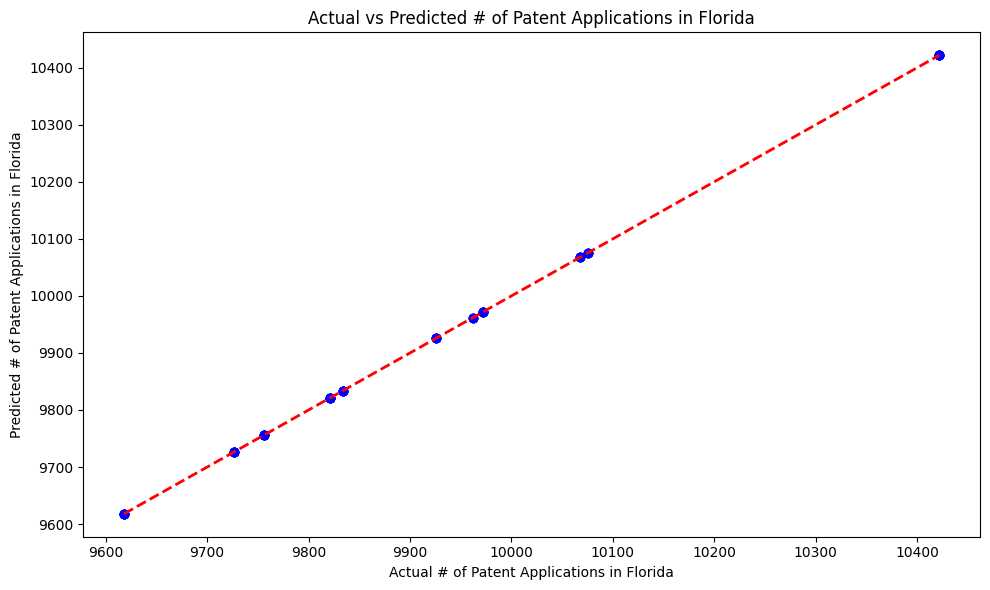

Summary Statistics of # of Patent Applications in Florida:
count      737.000000
mean      9925.500000
std        208.018431
min       9618.000000
25%       9756.000000
50%       9925.500000
75%      10068.000000
max      10422.000000
Name: # of Patent Applications in Florida, dtype: float64


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('All Training Tables - Training Data.csv')

# Strip any extra spaces from column names
df.columns = df.columns.str.strip()

# Print column names to verify
print("Columns in DataFrame:")
print(df.columns)

# Select features for the model
features = [
    'Year', 'County Code', 'Business Apps 2005', 'Business Apps 2006',
    'Business Apps 2007', 'Business Apps 2008', 'Business Apps 2009',
    'Business Apps 2010', 'Business Apps 2011', 'Business Apps 2012',
    'Business Applications', 'University R&D Spending',
    'Median Household Income',
    'State, Local and Federal Funds for Pupils by School County'
]
target = '# of Patent Applications in Florida'

# Remove non-numeric characters and convert to float
for col in features + [target]:
    df[col] = df[col].replace('[\$,]', '', regex=True).astype(float)

# Check for missing values
print("Missing values in each column before handling:")
print(df.isnull().sum())

# Handle missing values by imputation
imputer = SimpleImputer(strategy='mean')
df[features] = imputer.fit_transform(df[features])
df[target] = imputer.fit_transform(df[[target]])

# Prepare the data
X = df[features]
y = df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model Performance:")
print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

# Print feature importances
print("Feature Importances:")
for feature, importance in zip(features, model.feature_importances_):
    print(f"{feature}: {importance}")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual # of Patent Applications in Florida")
plt.ylabel("Predicted # of Patent Applications in Florida")
plt.title("Actual vs Predicted # of Patent Applications in Florida")
plt.tight_layout()
plt.show()

# Print summary statistics of the target variable
print("Summary Statistics of # of Patent Applications in Florida:")
print(df[target].describe())


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Create and train the Random Forest model with hyperparameters to prevent overfitting
model = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=4, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model Performance:")
print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

# Print feature importances
print("Feature Importances:")
for feature, importance in zip(features, model.feature_importances_):
    print(f"{feature}: {importance}")


Model Performance:
Mean Squared Error: 0.0
R-squared Score: 1.0
Feature Importances:
Year: 1.0
County Code: 0.0
Business Apps 2005: 0.0
Business Apps 2006: 0.0
Business Apps 2007: 0.0
Business Apps 2008: 0.0
Business Apps 2009: 0.0
Business Apps 2010: 0.0
Business Apps 2011: 0.0
Business Apps 2012: 0.0
Business Applications: 0.0
University R&D Spending: 0.0
Median Household Income: 0.0
State, Local and Federal Funds for Pupils by School County: 0.0


In [ ]:
import pandas as pd
!pip install google-colab-selenium[undetected]
import google_colab_selenium as gs
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time

# Initialize the browser driver
driver = gs.UndetectedChrome()

# Initialize an empty DataFrame to store the results
years = list(range(2015, 2025))
florida_cities = ['Miami', 'Alachua', 'Orlando', 'Parkland']
multi_index = pd.MultiIndex.from_product([years, florida_cities], names=['Year', 'City'])
results_df = pd.DataFrame(index=multi_index, columns=['Patent Count'])

for city in florida_cities:
    # Open the website
    driver.get(f'https://assignment.uspto.gov/patent/index.html#/patent/search/resultFilter?advSearchFilter=patAssigneeCity:%22{city}%22%7CpatAssigneeState:%22Florida%22&qc=2')

    execution_year_filter = WebDriverWait(driver, 10).until(
        EC.element_to_be_clickable((By.XPATH, '//*[@id="patAssignorEarliestExDate"]/div[1]/h4/a'))
    )
    execution_year_filter.click()

    show_more_container = WebDriverWait(driver, 20).until(
        EC.presence_of_element_located((By.XPATH, '//*[@id="filter.id"]/div/div/div/div[1]'))
    )
    show_more_link = show_more_container.find_element(By.XPATH, './a')
    driver.execute_script("arguments[0].click();", show_more_link)

    # Wait for the list of years to be fully loaded
    time.sleep(2)

    # Extract the numbers next to the years from 2015-2024
    year_elements = driver.find_elements(By.CSS_SELECTOR, 'ul.list-unstyled.filtersection-animate-container li')
    year = 2024
    for element in year_elements:
        count_text = element.find_element(By.CSS_SELECTOR, 'span.text-muted.pull-right.ng-binding').text
        results_df.loc[(year, city), 'Patent Count'] = count_text

        if year == 2015:
            break
        else:
            year -= 1

# Print the results DataFrame
print(results_df)

# Close the browser
driver.quit()

# Assuming you need to merge this data with your existing DataFrame
# Convert Patent Count to numeric
results_df['Patent Count'] = results_df['Patent Count'].replace('[\$,]', '', regex=True).astype(float)

# Reset index to merge with existing data
results_df = results_df.reset_index()

# Load the existing data
existing_df = pd.read_csv('All Training Tables - Training Data.csv')

# Merge dataframes (adjust according to your merging strategy)
combined_df = pd.merge(existing_df, results_df, how='left', left_on=['Year', 'City'], right_on=['Year', 'City'])

# Now you can use combined_df for further analysis or model building


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.4/65.4 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 476.0/476.0 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.8 MB/s eta 0:00:00
  Created wheel for undetected-chromedriver: filename=undetected_chromedriver-3.5.5-py3-none-any.whl size=47047 sha256=669074087d6a6a958121a918382cbd2e9145c896a237186abf68556217451e9e
  Stored in directory: /root/.cache/pip/wheels/cf/a1/db/e1275b6f7259aacd6b045f8bfcb1fcbc93827a3916ba55d5b7
Successfully built undetected-chromedriver


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

              Patent Count
Year City                 
2015 Miami             NaN
     Alachua           NaN
     Orlando           NaN
     Parkland          NaN
2016 Miami             NaN
     Alachua           NaN
     Orlando           NaN
     Parkland          NaN
2017 Miami             NaN
     Alachua           NaN
     Orlando           NaN
     Parkland          NaN
2018 Miami             NaN
     Alachua           NaN
     Orlando           NaN
     Parkland          NaN
2019 Miami             NaN
     Alachua           NaN
     Orlando           NaN
     Parkland          NaN
2020 Miami             NaN
     Alachua           NaN
     Orlando           NaN
     Parkland          NaN
2021 Miami             NaN
     Alachua           NaN
     Orlando           NaN
     Parkland          NaN
2022 Miami             NaN
     Alachua           NaN
     Orlando           NaN
     Parkland          NaN
2023 Miami             NaN
     Alachua           NaN
     Orlando           NaN
 

KeyError: 'City'

#### **Trying a Support Vector Regressor** (outdated)

In [ ]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=19)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize and train the Support Vector Regressor
# High degree polynomials work best
svr = SVR(kernel='rbf')
svr.fit(X_train, y_train)

# Make predictions
y_pred = svr.predict(X_test)

# Model evaluation
mae = mean_absolute_error(y_pred, y_test)
mse = mean_squared_error(y_pred, y_test)
r2 = r2_score(y_pred, y_test)

# Print the evaluation metrics
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Absolute Error: 0.0004169312962642322
Mean Squared Error: 1.842232681528882e-07
R^2 Score: 0.0
